<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%9F%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперимент: "Последовательно"

Проект: "Оптимизация инвестиционных портфелей методами машинного обучения"

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург

10.01.2021

[VK](https://vk.com/alekseyenin)
[OK](http://ok.ru/profile/404477133)
[Twitter](https://twitter.com/EninAleksey)
[FB](https://www.facebook.com/alex.prog.1)
[Telegramm](https://t.me/AleseyEnin)
[Habr](https://habr.com/ru/users/eavprog/posts/)
[VC](https://vc.ru/u/262921-aleksey-enin)
[GitHub](https://github.com/prog815)

# Загрузка библиотек

In [1]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-js65patm
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-js65patm
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=50a8df16cc792ea320cf6d95d043576797cb69e1b40e9bab46fac59e056e4ede
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhhrt01u/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-lvnml7v1
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-lvnml7v1
  Created wheel for progOrder: filename=progOrder-0.0.5-cp36-none-any.whl size=2485 sha256=dad8056aa31fd3874766c82dec3fa33c85773a5dd3baaef6b1e6c7aedb8cfb1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-v6c5d4ix/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [2]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData, kach, bs2y, y2bs
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Загрузка данных

In [3]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-30,272.50,274.24,270.12,271.65,31509500
2021-01-04,274.67,276.60,270.61,272.00,48799460
2021-01-05,272.67,275.70,270.28,275.20,45554100


In [4]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-30,272.50,274.24,270.12,271.65,31509500,0.001838,0.008235,-0.006912,-0.001287
2021-01-04,274.67,276.60,270.61,272.00,48799460,0.011117,0.018222,-0.003828,0.001288
2021-01-05,272.67,275.70,270.28,275.20,45554100,0.002463,0.013603,-0.006324,0.011765


# Поиск гиперпараметров

## Целевая функция

In [5]:
# %%time

orderLifeLen = 50                           # срок жизни ордера

# (+) !!! - определить выборки

allLen = data.shape[0]                      # размер всей выборки
allIdx = np.arange(allLen,dtype=np.int16)
testPart = 0.1                              # доля тестовой
testLen = int(np.round(allLen*testPart))    # длина тестовой выборки
trainLen = allLen - testLen                 # длина трейновой выборки (обучающая + валидационная)
valLen = orderLifeLen                       # длина валидационной выборки

# --------------------------------------------------

def get_X(lookback):
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    X = np.hstack((X,np.vstack((data.index.month,data.index.day,data.index.dayofweek)).T))
    return X

# --------------------------------------------------

def getQualityMethod(lookback,     # окно задержки
                     learnLen,     # глубина обучения
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
    
    # (+) !!! - случайная точка расчета
    randomPoint = np.random.randint(1+learnLen+lookback,trainLen)

    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = get_X(lookback)
    y = b*2+s

    # разделение выборок
    X_learn = X[(randomPoint-learnLen):randomPoint]
    y_learn = y[(randomPoint-learnLen):randomPoint]
    X_valid = X[randomPoint:(randomPoint+valLen)]
    y_valid = y[randomPoint:(randomPoint+valLen)]

    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)
    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    res = kach(num2bs(pred_valid),num2bs(y_valid),dTP,dSL)

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -0.01

    return res

res = getQualityMethod(30,1000,7,200,0.004,0.01)
print(res)

-0.00322


In [6]:
testLen

326

## Создание модели

### Создание

In [7]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      learnLen = range(100,trainLen-300-2),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.01,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [8]:
fn = '/content/drive/My Drive/prog/model_p_09.01.2021.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)


## Бесконечный цикл обучения

In [34]:
while True:
    modelGA.fit(50,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

4932 {'quality': -8.2e-05, 'lookback': 296, 'learnLen': 2631, 'max_depth': 79, 'n_estimators': 104, 'dTP': 0.006, 'dSL': 0.0071}
4942 {'quality': 5.299999999999998e-05, 'lookback': 296, 'learnLen': 2602, 'max_depth': 46, 'n_estimators': 59, 'dTP': 0.0068, 'dSL': 0.0073}
4951 {'quality': -2.999999999999999e-05, 'lookback': 282, 'learnLen': 2625, 'max_depth': 48, 'n_estimators': 95, 'dTP': 0.0054, 'dSL': 0.0069}
4961 {'quality': -0.01, 'lookback': 298, 'learnLen': 2489, 'max_depth': 42, 'n_estimators': 122, 'dTP': 0.0069, 'dSL': 0.0067}
4971 {'quality': 3.4999999999999977e-05, 'lookback': 269, 'learnLen': 2631, 'max_depth': 41, 'n_estimators': 65, 'dTP': 0.0062, 'dSL': 0.0071}
finish -  4974 {'quality': -6.8e-05, 'lookback': 287, 'learnLen': 2621, 'max_depth': 44, 'n_estimators': 64, 'dTP': 0.0066, 'dSL': 0.0067}
4983 {'quality': -1.599999999999999e-05, 'lookback': 292, 'learnLen': 2573, 'max_depth': 45, 'n_estimators': 113, 'dTP': 0.0061, 'dSL': 0.0069}
4993 {'quality': -0.01, 'lookback

KeyboardInterrupt: ignored

## Графики оптимизации параметров в генетике

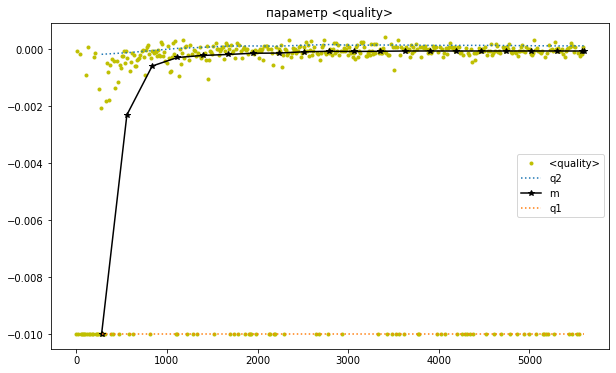

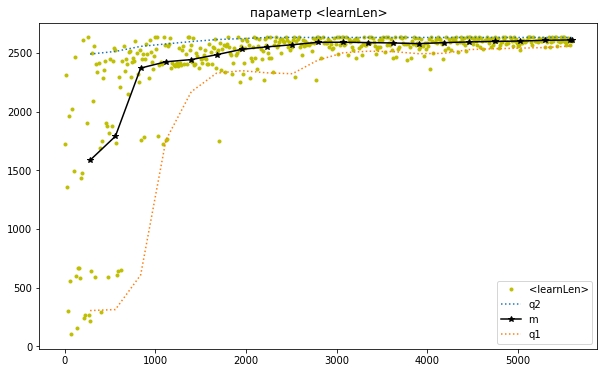

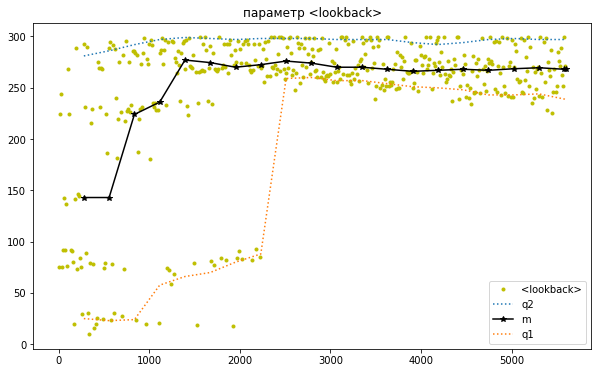

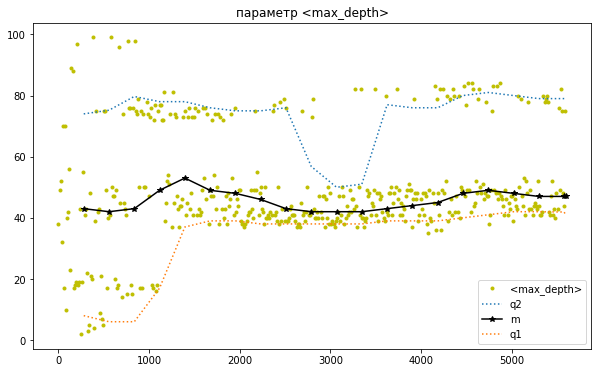

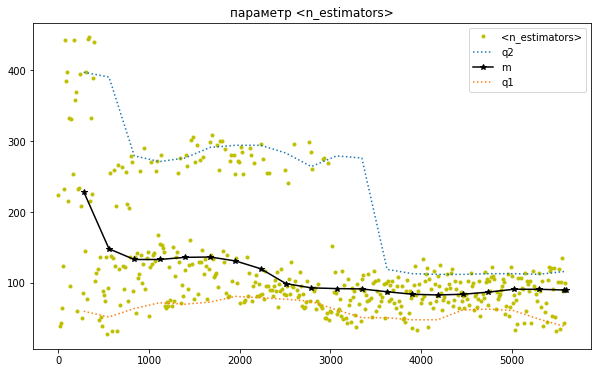

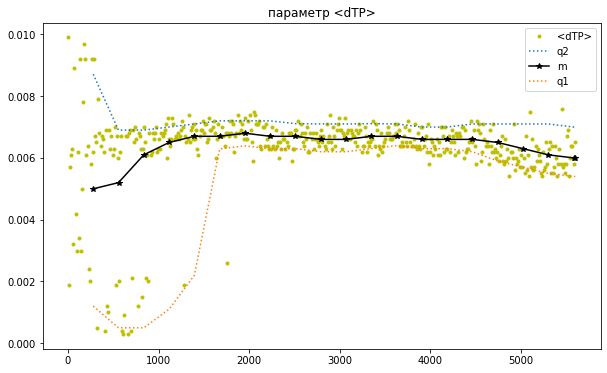

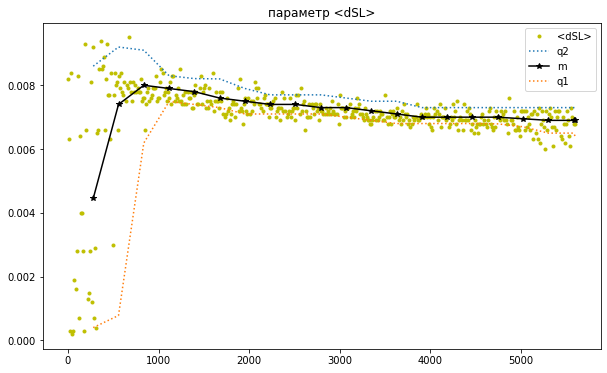

In [35]:
modelGA.plot_hist_new(('quality','learnLen','lookback','max_depth','n_estimators','dTP','dSL'))

## Положительные

In [36]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


58 {'quality': 5.4000000000000005e-05, 'lookback': 19, 'learnLen': 198, 'max_depth': 96, 'n_estimators': 452, 'dTP': 0.0056, 'dSL': 0.0058}
73 {'quality': 2.8999999999999997e-05, 'lookback': 85, 'learnLen': 2030, 'max_depth': 99, 'n_estimators': 18, 'dTP': 0.0029, 'dSL': 0.0055}
132 {'quality': 8.4e-05, 'lookback': 92, 'learnLen': 160, 'max_depth': 23, 'n_estimators': 95, 'dTP': 0.0092, 'dSL': 0.0064}
137 {'quality': 2.599999999999999e-05, 'lookback': 225, 'learnLen': 1595, 'max_depth': 55, 'n_estimators': 35, 'dTP': 0.0062, 'dSL': 0.008}
155 {'quality': 4e-06, 'lookback': 175, 'learnLen': 1802, 'max_depth': 40, 'n_estimators': 380, 'dTP': 0.0004, 'dSL': 0.0082}
184 {'quality': 5.7999999999999994e-05, 'lookback': 228, 'learnLen': 2503, 'max_depth': 78, 'n_estimators': 383, 'dTP': 0.0029, 'dSL': 0.0081}
213 {'quality': 6.2e-05, 'lookback': 281, 'learnLen': 1612, 'max_depth': 9, 'n_estimators': 145, 'dTP': 0.0041, 'dSL': 0.0061}
230 {'quality': 9.599999999999999e-05, 'lookback': 228, 'le

## Параметры лучшей

In [37]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0069,
 'dTP': 0.0061,
 'learnLen': 2602,
 'lookback': 267,
 'max_depth': 57,
 'n_estimators': 80}

# Тестирование лучшей

## входы и выходы обучения

In [38]:
# подготовка сигналов
b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=best_par['dSL'],dTP=best_par['dTP'])

# подготовка входов
X = get_X(best_par['lookback'])
y = b*2+s

## цикл расчета

In [39]:
b_ = b * np.nan
s_ = s * np.nan

# цикл по точкам расчета
for calcPoint in range(best_par['learnLen']+best_par['lookback'],allLen-valLen,valLen):
    
    # обучающая выборка
    X_learn = X[(calcPoint-best_par['learnLen']):calcPoint]
    y_learn = y[(calcPoint-best_par['learnLen']):calcPoint]
    X_test = X[calcPoint:(calcPoint+valLen)]
    
    # создание модели
    model_test = RandomForestClassifier(max_depth=best_par['max_depth'],class_weight='balanced',n_estimators=best_par['n_estimators'])

    # обучение модели
    model_test.fit(X_learn, y_learn)

    # прогноз модели
    pred_test = model_test.predict(X_test)
    b_test,s_test = y2bs(pred_test)

    # запись результатов
    b_[calcPoint:(calcPoint+valLen)] = b_test
    s_[calcPoint:(calcPoint+valLen)] = s_test

    print(calcPoint,allLen)



2869 3260
2919 3260
2969 3260
3019 3260
3069 3260
3119 3260
3169 3260


## оценка качества в тесте

## Таблица результатов

In [40]:
df_=pd.DataFrame(index=data.index)
df_['BUY'] = b_
df_['BUY_open'] = data['<CLOSE>']
df_['BUY_tp'] = np.round(data['<CLOSE>']*(1+best_par['dTP']),2)
df_['BUY_sl'] = np.round(data['<CLOSE>']*(1-best_par['dSL']),2)
df_['SELL'] = s_
df_['SELL_open'] = data['<CLOSE>']
df_['SELL_tp'] = np.round(data['<CLOSE>']*(1-best_par['dTP']),2)
df_['SELL_sl'] = np.round(data['<CLOSE>']*(1+best_par['dSL']),2)
df_

,BUY,BUY_open,BUY_tp,BUY_sl,SELL,SELL_open,SELL_tp,SELL_sl
<DATE>,,,,,,,,
2008-01-09,NaN,101.85,102.47,101.15,NaN,101.85,101.23,102.55
2008-01-10,NaN,103.53,104.16,102.82,NaN,103.53,102.90,104.24
2008-01-11,NaN,104.70,105.34,103.98,NaN,104.70,104.06,105.42
2008-01-14,NaN,105.00,105.64,104.28,NaN,105.00,104.36,105.72
2008-01-15,NaN,105.71,106.35,104.98,NaN,105.71,105.07,106.44
...,...,...,...,...,...,...,...,...
2020-12-30,NaN,271.65,273.31,269.78,NaN,271.65,269.99,273.52
2021-01-04,NaN,272.00,273.66,270.12,NaN,272.00,270.34,273.88
2021-01-05,NaN,275.20,276.88,273.30,NaN,275.20,273.52,277.10


## Сигналы

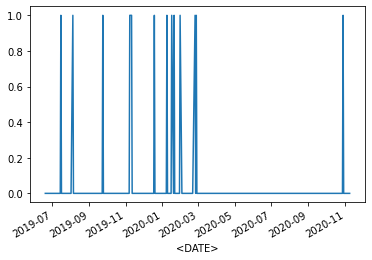

In [41]:
df_['BUY'].plot()

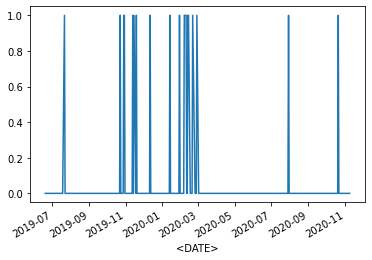

In [42]:
df_['SELL'].plot()

## Качество на тесте

In [43]:
bs_y = np.vstack((b,s)).T
bs_y_ = np.vstack((b_,s_)).T
idx = ~np.any(np.isnan(bs_y + bs_y_),axis=1)
kachTest = kach(bs_y_[idx],bs_y[idx],best_par['dTP'],best_par['dSL'])
print('kachTest',kachTest,'%/year',((kachTest+1)**252-1)*100)

kachTest -4.557142857142856e-05 %/year -1.1418569262718337
